In [45]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn import metrics, model_selection
import platform; platform.mac_ver()
from transformers import AutoTokenizer, BertForSequenceClassification, BertConfig, TrainingArguments, Trainer, get_scheduler,  DataCollatorWithPadding, get_linear_schedule_with_warmup
from datasets import load_metric,  Dataset, DatasetDict, load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
df = pd.read_csv("data/innova.csv")
df = df[df.sostenible != 2].reset_index(drop=True)
df = df.rename({'objetivo':'text', 'sostenible':'label'}, axis=1)
df = df[['text', 'label']]
df = df.dropna()
df.head()

,text,label
0,diseñar un modelo de producción de biomasa for...,1
1,desarrollar conocimiento por medio de la inves...,1
2,el objetivo de este proyecto es potenciar la p...,0
3,"fortalecer la definición y formulación, además...",0
4,"se busca generar, por medio de la herramienta ...",0


In [17]:
df.label.value_counts('labels')

0    0.631784
1    0.368216
Name: label, dtype: float64

In [18]:
class args:
    model = "dccuchile/bert-base-spanish-wwm-uncased"
    epochs = 5 #2
    batch_size = 32 #32
    learning_rate = 2e-5  #2e-5 
    train_batch_size = 32 
    valid_batch_size = 32
    max_len = 128 # 128
    accumulation_steps = 1
    test_size = 0.3 #03
    num_labels = 2
    #problem_type = 'multi_label_classification'
    device =  torch.device('mps')

In [19]:
tokenizer = AutoTokenizer.from_pretrained(args.model)

In [20]:
df_train, df_valid = model_selection.train_test_split(df, test_size=args.test_size, stratify=df.label.values)

In [21]:
data_train = Dataset.from_pandas(df_train)
data_valid = Dataset.from_pandas(df_valid)

In [22]:
Bertdf = DatasetDict()
Bertdf['train'] = data_train
Bertdf['test'] = data_valid

In [5]:
imdb = load_dataset("imdb")

Reusing dataset imdb (/Users/fabianalexis/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [72]:
imdb['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [23]:
Bertdf['train'][0]

{'text': 'escalar comercialmente el producto ppoff-ftgl en el mercado hortofrutícola nacional y acelerar la introducción del mismo en mercados internacionales para uva de mesa y hortalizas, mediante un plan de comercialización y escalamiento que explote las características de valor diferenciadoras del producto tecnológico; valide y certifique su desempeño técnico en los mercados de destino, incremente la capacidad tecnológica de la empresa y proteja la propiedad intelectual del desarrollo a nivel global.',
 'label': 0,
 '__index_level_0__': 7287}

In [24]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=args.max_len)

In [25]:
tokenized_df= Bertdf.map(preprocess_function, batched=True)

  0%|          | 0/6 [00:00<?, ?ba/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3 [00:00<?, ?ba/s]

In [78]:
tokenized_df

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4621
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3081
    })
})

In [27]:
tokenizer.convert_ids_to_tokens(tokenized_df['train']['input_ids'][3]) 

['[CLS]',
 'evaluar',
 'en',
 'terreno',
 'la',
 'aplicación',
 'de',
 'un',
 'nuevo',
 'y',
 'mejorado',
 'tratamiento',
 'terapéu',
 '##tico',
 'basado',
 'en',
 'células',
 'autó',
 '##log',
 '##as',
 'en',
 'sc',
 '##af',
 '##old',
 'in',
 '##bio',
 '##dr',
 '##m',
 '+',
 'c',
 'para',
 'la',
 'curación',
 'de',
 'ú',
 '##lc',
 '##eras',
 'de',
 'pie',
 'diab',
 '##ético',
 '.',
 '[SEP]']

In [28]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

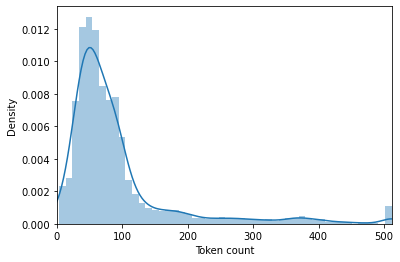

In [29]:
sns.distplot(token_lens)
plt.xlim([0, 512])
plt.xlabel('Token count')

In [30]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [31]:
config = BertConfig.from_pretrained(args.model, num_labels= args.num_labels)
#config.num_labels = args.num_labels
#config.problem_type = args.problem_type
model = BertForSequenceClassification(config=config).to(args.device)  # remember to move to MPS!

In [33]:

#batches_per_epoch = len(tokenized_df["train"]) // args.batch_size
#total_train_steps = int(batches_per_epoch * args.epochs)


In [46]:
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
num_training_steps = args.epochs *len(tokenized_df["train"]) 
lr_scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
optimizers=optimizer, lr_scheduler

In [34]:
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [47]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=args.learning_rate,
    per_device_train_batch_size=args.train_batch_size,
    per_device_eval_batch_size=args.valid_batch_size,
    num_train_epochs=args.epochs,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_df["train"],
    eval_dataset=tokenized_df["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    optimizers= optimizers
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5391
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 338


  0%|          | 0/338 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 2431.1787, 'train_samples_per_second': 4.435, 'train_steps_per_second': 0.139, 'train_loss': 0.5380176792483358, 'epoch': 2.0}


TrainOutput(global_step=338, training_loss=0.5380176792483358, metrics={'train_runtime': 2431.1787, 'train_samples_per_second': 4.435, 'train_steps_per_second': 0.139, 'train_loss': 0.5380176792483358, 'epoch': 2.0})

In [48]:
trainer.evaluate(tokenized_df['test'])

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2311
  Batch size = 32


  0%|          | 0/73 [00:00<?, ?it/s]

{'eval_loss': 0.49431896209716797,
 'eval_accuracy': 0.7589787970575509,
 'eval_f1': 0.6924351187189398,
 'eval_runtime': 103.9847,
 'eval_samples_per_second': 22.224,
 'eval_steps_per_second': 0.702,
 'epoch': 2.0}

In [49]:
outputs = trainer.predict(tokenized_df['test'])

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2311
  Batch size = 32


  0%|          | 0/73 [00:00<?, ?it/s]

In [59]:
predictions = outputs.predictions
predictions = np.argmax(predictions, axis=1)
predictions

array([1, 0, 0, ..., 0, 1, 0])

In [58]:
np.array(df_train['label'].values)

array([0, 0, 0, ..., 1, 0, 0])

In [51]:
predictions = outputs.predictions
predictions


array([[-0.10045042,  0.7344741 ],
       [ 0.980232  , -0.2824431 ],
       [ 2.6849244 , -2.198826  ],
       ...,
       [ 1.2312837 , -0.52125496],
       [-2.7470272 ,  2.7305367 ],
       [ 0.80468714, -0.10896454]], dtype=float32)

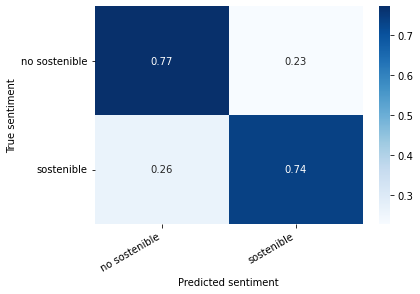

In [80]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')


class_names = ['no sostenible', 'sostenible']
cm = metrics.confusion_matrix(outputs.label_ids, predictions, normalize='true')
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)